In [54]:
from mask_utils.utils import *
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import os
from shutil import copyfile
from tqdm.notebook import tqdm

In [2]:
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
          (0, 255, 255), (255, 0, 255), (0, 0, 0), (255, 255, 255)]
random.seed(2021)

In [3]:
with open('../MERGE_OCEAN/Annotations/merge_ocean_train.json', 'r') as json_file:
    train_anno = json.load(json_file)
json_file.close()
list_images = train_anno['images']
list_names = [item['name'] for item in train_anno['categories']]

In [91]:
def color_histogram(image_dict: dict) -> np.array:
    img_path = image_dict['file_name']
    img = cv2.imread(img_path)

    # Calculate histogram without mask
    hist1 = cv2.calcHist([img],[0],None,[32],[0,256])
    hist2 = cv2.calcHist([img],[1],None,[32],[0,256])
    hist3 = cv2.calcHist([img],[2],None,[32],[0,256])
    
    color_hist = np.concatenate([hist1, hist2, hist3]).reshape(-1)
    return color_hist

In [92]:
X = []
for img_dict in tqdm(train_anno['images']):
    X.append(color_histogram(img_dict))
X = np.array(X)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [93]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in tqdm(K):
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

Widget Javascript not detected.  It may not be installed or enabled properly.


In [94]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 458142.7435515064
2 : 446971.41870713426
3 : 374553.4979820726
4 : 352688.61548548203
5 : 342646.8141230704
6 : 338410.7484952969
7 : 331361.65789626614
8 : 312878.503256586
9 : 307459.8990261326


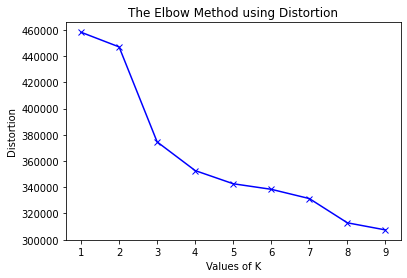

In [95]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [96]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 2798526870323200.0
2 : 2208233812918272.0
3 : 1752201970057216.0
4 : 1440379962392576.0
5 : 1300642261893120.0
6 : 1183469245825024.0
7 : 997886527537152.0
8 : 907892534280192.0
9 : 780212551811072.0


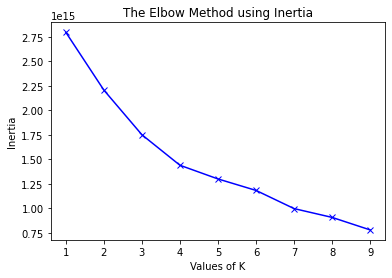

In [97]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [107]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
labels = kmeans.labels_

In [108]:
for i in range(3):
    class_i = list(np.where(labels == i)[0])
    img_folder = '../color_cluster/{}'.format(i)
    if not os.path.exists(img_folder):
        os.makedirs(img_folder)
    for j in random.sample(class_i, min(20, len(class_i))):
        img_path = train_anno['images'][j]['file_name']
        img_id = img_path.split('/')[-1]
        save_path = os.path.join(img_folder, img_id)
        
        copyfile(img_path, save_path)
        

In [ ]:
transformed_annotations = dict()
transformed_annotations['categories'] = deepcopy(train_anno['categories'])
transformed_annotations['images'] = []
transformed_annotations['annotations'] = []
count_img = 0
count_ins = 0
num_sample = 10
for mis_tuple in tqdm(miscls):
    
    first_samples = get_class_samples(list_images, list(mis_tuple)[0], num_sample)
    second_samples = get_class_samples(list_images, list(mis_tuple)[1], num_sample)
    
    for i in range(min(len(first_samples), len(second_samples))):
        transformed_img, polygon, transformed_imganno, transformed_anno = mixup_image(first_samples[i], second_samples[i], count_img)
        count_img += 1
        transformed_annotations['images'].append(transformed_imganno)
        
        for j in range(len(transformed_anno)):
            transformed_anno[j]['id'] = count_ins
            count_ins += 1
        
        transformed_annotations['annotations'].extend(transformed_anno)
        
        cv2.imwrite(transformed_imganno['file_name'][1:], transformed_img)

In [ ]:
with open('./MERGE_OCEAN/Annotations/augmentation++.json', 'w') as json_file:
    json.dump(transformed_annotations, json_file)
json_file.close()